In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


## PRA PROSES

In [2]:
# Memuat dataset dari file
file_path = 'dataset.csv'
dataset = pd.read_csv(file_path)

# Menampilkan dataset asli
dataset['Y'] = dataset['Y'].astype(int)
dataset[dataset["Y"] == 10] = 1
print("Dataset:")
print(dataset.head())


Dataset:
   Participant       EAR       MAR       MOE  Y
0          1.0  0.352255  0.998264  2.833928  0
1          1.0  0.324341  0.993003  3.061603  0
2          1.0  0.367728  0.999941  2.719243  0
3          1.0  0.326678  1.000042  3.061252  0
4          1.0  0.204691  0.975033  4.763446  0


In [3]:
# Normalisasi dataset (kecuali kolom 'Y')

scaler = MinMaxScaler()
print("\n Dataset sebelum dilakukan normalisasi (kolom 'EAR','MAR','MOE'):")
print(dataset.head()[['EAR','MAR','MOE']])
normalized_data = scaler.fit_transform(dataset[['EAR', 'MAR', 'MOE']])

normalized_df = pd.DataFrame(normalized_data, columns=['EAR', 'MAR', 'MOE'])

# Menggabungkan kembali data yang dinormalisasi dengan kolom 'Y'
normalized_df['Y'] = dataset['Y']

# Menampilkan dataset setelah menambahkan kembali kolom 'Y'
print("\nDataset setelah normalisasi (kolom 'EAR', 'MAR', 'MOE'):")
print(normalized_df.head())


 Dataset sebelum dilakukan normalisasi (kolom 'EAR','MAR','MOE'):
        EAR       MAR       MOE
0  0.352255  0.998264  2.833928
1  0.324341  0.993003  3.061603
2  0.367728  0.999941  2.719243
3  0.326678  1.000042  3.061252
4  0.204691  0.975033  4.763446

Dataset setelah normalisasi (kolom 'EAR', 'MAR', 'MOE'):
        EAR       MAR       MOE  Y
0  0.294784  0.197775  0.159478  0
1  0.264394  0.169532  0.179277  0
2  0.311630  0.206777  0.149505  0
3  0.266938  0.207320  0.179246  0
4  0.134128  0.073061  0.327269  0


In [4]:
# Membuat urutan data untuk input LSTM dengan panjang urutan 5 (mewakili 5 detik)
SEQ_LENGTH = 5

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(normalized_df.values, SEQ_LENGTH)

# Menampilkan beberapa contoh urutan data (sequences)
print("\nContoh urutan data (X):")
print(X[:2])
print("\nContoh label (y):")
print(y[:2])



Contoh urutan data (X):
[[[0.29478431 0.19777497 0.15947841]
  [0.26439416 0.16953213 0.17927697]
  [0.31163035 0.20677735 0.14950536]
  [0.26693804 0.20732034 0.17924644]
  [0.13412813 0.07306105 0.32726921]]

 [[0.26439416 0.16953213 0.17927697]
  [0.31163035 0.20677735 0.14950536]
  [0.26693804 0.20732034 0.17924644]
  [0.13412813 0.07306105 0.32726921]
  [0.26211657 0.15691692 0.1803712 ]]]

Contoh label (y):
[0. 0.]


In [5]:
# Memisahkan data menjadi set pelatihan dan pengujian
split_ratio = 0.8
split = int(split_ratio * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## PELATIHAN MODEL

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Kompilasi Model 
learning_rate = 0.000005
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10800     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Pelatihan model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
model.save('lstm_epoch50_11.h5')

Epoch 1/50
252/252 [==============================] - 7s 11ms/step - loss: 1.5302 - accuracy: 0.5303 - val_loss: 1.5235 - val_accuracy: 0.3929
Epoch 2/50
252/252 [==============================] - 2s 8ms/step - loss: 1.5066 - accuracy: 0.5494 - val_loss: 1.5016 - val_accuracy: 0.3929
Epoch 3/50
252/252 [==============================] - 2s 7ms/step - loss: 1.4834 - accuracy: 0.5515 - val_loss: 1.4801 - val_accuracy: 0.3929
Epoch 4/50
252/252 [==============================] - 2s 7ms/step - loss: 1.4613 - accuracy: 0.5494 - val_loss: 1.4589 - val_accuracy: 0.3929
Epoch 5/50
252/252 [==============================] - 2s 7ms/step - loss: 1.4387 - accuracy: 0.5478 - val_loss: 1.4379 - val_accuracy: 0.3929
Epoch 6/50
252/252 [==============================] - 2s 8ms/step - loss: 1.4164 - accuracy: 0.5468 - val_loss: 1.4170 - val_accuracy: 0.3929
Epoch 7/50
252/252 [==============================] - 2s 7ms/step - loss: 1.3939 - accuracy: 0.5475 - val_loss: 1.3962 - val_accuracy: 0.3938
Epoch

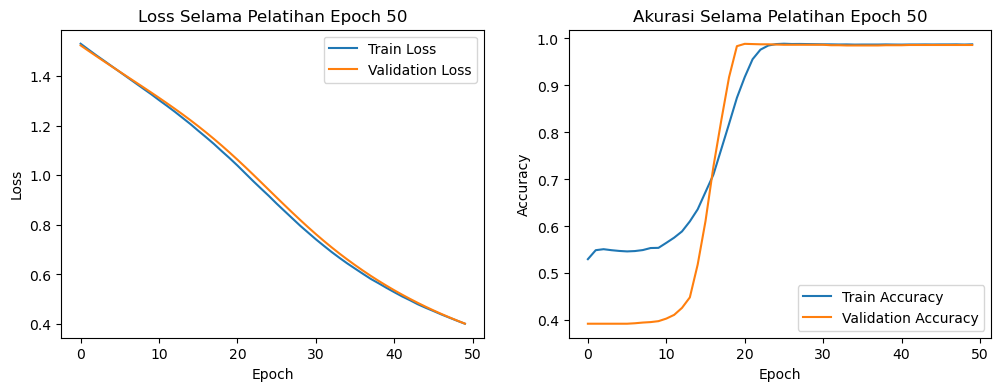

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi loss dan akurasi
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Selama Pelatihan Epoch 50')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Akurasi Selama Pelatihan Epoch 50')
plt.legend()

plt.show()


In [9]:
from tensorflow.keras.models import load_model

# Memuat model dari file
model = load_model('lstm_epoch50_11.h5')

# Menampilkan ringkasan model untuk memastikan model telah dimuat dengan benar
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10800     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


## EVALUASI MODEL

In [10]:
import numpy as np

# Identifikasi indeks kelas 'Sleepy' dan 'Not Sleepy' dalam y_test
sleepy_indices = np.where(y_test == 1)[0]
non_sleepy_indices = np.where(y_test == 0)[0]

# Mengambil sebagian data 'Sleepy' untuk dihapus
np.random.seed(42)  # Untuk reproducibility
sleepy_indices_to_remove = np.random.choice(sleepy_indices, size=119, replace=False)

# Menyimpan indeks yang tersisa
remaining_indices = np.setdiff1d(np.arange(len(y_test)), sleepy_indices_to_remove)

# Mengurangi jumlah data y_test dan X_test
X_test = X_test[remaining_indices]
y_test = y_test[remaining_indices].astype(int)  # Konversi ke integer

# Memastikan jumlah data setelah pengurangan
print(y_test.shape)


(2400,)


75/75 [==============================] - 1s 2ms/step - loss: 0.3936 - accuracy: 0.9858
Test Accuracy: 98.58%
315/315 [==============================] - 2s 3ms/step - loss: 0.3907 - accuracy: 0.9869
Train Accuracy: 98.69%
75/75 [==============================] - 1s 4ms/step


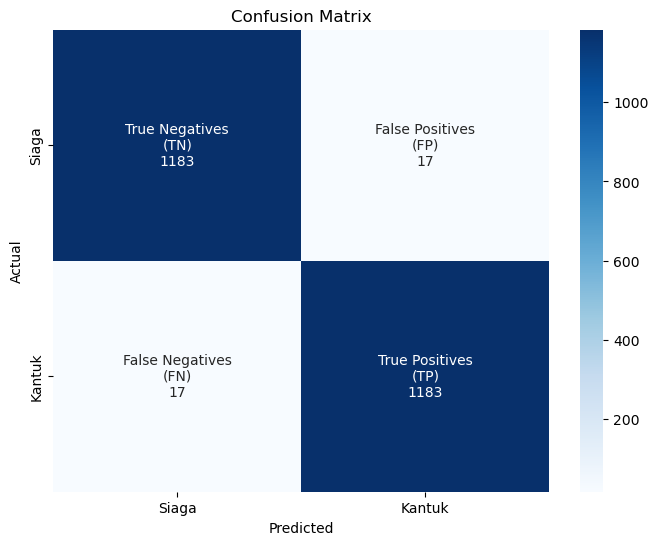

              precision    recall  f1-score   support

       Siaga       0.99      0.99      0.99      1200
      Kantuk       0.99      0.99      0.99      1200

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the reduced test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Predict on the reduced test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)


# Create labels for the confusion matrix
labels = np.array([['True Negatives\n(TN)', 'False Positives\n(FP)'],
                   ['False Negatives\n(FN)', 'True Positives\n(TP)']])

# Combine labels and values into one string for each cell
combined_labels = np.asarray([f'{label}\n{value}' for label, value in zip(labels.flatten(), cm.flatten())]).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=combined_labels, fmt='', cmap='Blues', xticklabels=['Siaga', 'Kantuk'], yticklabels=['Siaga', 'Kantuk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Siaga', 'Kantuk']))
